In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision as tv
from torchvision.transforms import v2
import torch.nn.functional as F

from tqdm import tqdm

torch_seed = 37
t.manual_seed(torch_seed)

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

In [3]:
fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]
fav_image_inf = imagenet_val_inference[fav_pic_index][0].unsqueeze(0)
toImage = v2.ToPILImage()

test_size = 128
dataloader = t.utils.data.DataLoader(dataset=imagenet_val_inference, batch_size=test_size)
test_images, _ = next(iter(dataloader))
test_images = test_images.to(device)

In [4]:
from utils.diffeo_container import sparse_diffeo_container

sparse_diffeos = sparse_diffeo_container(224, 224)
sparse_diffeos.sparse_AB_append(2,2,1,1,1)
sparse_diffeos.get_all_grid()
sparse_diffeos.to(device)
inv_diffeo = sparse_diffeos.get_inverse_grid()
inv_diffeo.to(device)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1817.06it/s]


In [5]:
class add_bias_to_AB(nn.Module):
  def __init__(self, AB, extra_freq_scaling = 1):
    # grid should have the shape of a grid_sample grid, i.e. (Channel, X, Y, 2)
    super().__init__()
    _, _, x_cutoff, y_cutoff = AB.shape
    self.AB = F.pad(AB,(0,(extra_freq_scaling) * y_cutoff, 0, (extra_freq_scaling) * x_cutoff),mode = 'constant', value = 0)
    # self.bias = nn.Parameter(self.AB.abs().sum() * (t.randint_like(self.AB, 1) - 1/2)/self.AB.numel())
    # self.bias = nn.Parameter(t.rand_like(self.AB))
    self.bias = nn.Parameter(t.rand_like(self.AB)/self.AB.numel())
    self.result = AB
  def forward(self):
    self.result = self.bias + self.AB
    return self.result
  @property
  def result_magnitude(self):
    return self.result[0].detach().abs().sum(), self.result[1].detach().abs().sum()
  @property
  def bias_magnitude(self):
    return self.bias[0].detach().abs().sum(), self.bias[1].detach().abs().sum()
  @property
  def original_magnitude(self):
    return self.AB[0].detach().abs().sum(), self.AB[1].detach().abs().sum()

In [6]:
AB_original = t.cat([t.stack(sparse_diffeos.A), t.stack(sparse_diffeos.B)])
AB = add_bias_to_AB(-AB_original.to(device), extra_freq_scaling = 10).to(device)
# AB = add_bias_to_AB(t.zeros_like(-AB_original).to(device), extra_freq_scaling = 0).to(device)
loss_fn = nn.MSELoss()
loss_cos = nn.CosineSimilarity()
loss_l1 = nn.L1Loss()
inv_loss_hist = []
cos_loss_hist = []
cos_sim_hist = []
AB_mag = []

In [7]:
from utils.distortion import compose_diffeo_from_left, create_grid_sample
from utils.diffeo_container import diffeo_container
from utils.get_model_activation import get_flatten_children

optimizer = t.optim.Adagrad(AB.parameters(), lr = 0.1)

num_epochs = 1000
# ref_grid = compose_diffeo_from_left(inv_grid[0],sparse_diffeos[0]).to(device)
id_grid = sparse_diffeos.get_id_grid()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    new_AB = AB()
    with t.device(device):
        grid = create_grid_sample(224, 224, new_AB[0], new_AB[1])
    un_distorted = compose_diffeo_from_left(grid,sparse_diffeos[0])
    unreg_loss = loss_fn(un_distorted, id_grid)
    loss = unreg_loss * (1 + 0.1 * AB.result.abs().sum()/AB.AB.abs().sum())
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

    if (epoch) % 50 == 0:
          with t.no_grad(): 
            inv_loss_hist.append(unreg_loss.item())
            AB_mag.append(AB.result.abs().sum().item()/2)
            AB.bias[t.abs(AB.bias) < 1e-7] = 0
          # print(loss.item())

/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 108.48it/s]


/tmp/ipykernel_724350/3804172420.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[2].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)


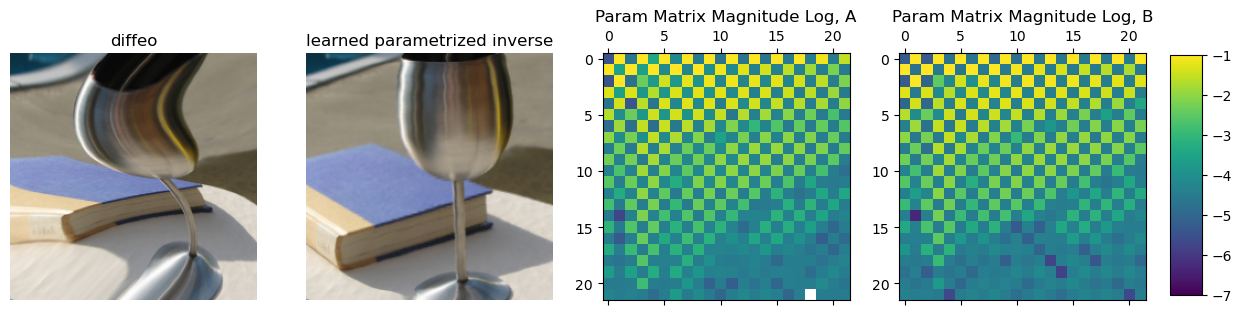

In [8]:
fig, axes = plt.subplots(1, 4, figsize = (4 * 4 ,4))
axes[0].imshow(toImage(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0].squeeze()))
axes[0].set_title('diffeo')
axes[1].imshow(toImage(F.grid_sample(sparse_diffeos(fav_image.unsqueeze(0).to(device))[0], grid, align_corners = True).squeeze()))
axes[1].set_title('learned parametrized inverse')

axes[2].matshow(np.log10(AB.result[0,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
axes[2].set_title('Param Matrix Magnitude Log, A')
cb = axes[3].matshow(np.log10(AB.result[1,0].detach().cpu().abs().numpy()), vmin = -7, vmax = -1)
axes[3].set_title('Param Matrix Magnitude Log, B')

fig.subplots_adjust(right=0.835)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(cb, cax=cbar_ax)
[ax.axis('off') for i, ax in enumerate(axes) if i<2];

In [9]:
inv_AB = new_AB.detach()
with t.device(device): 
    dowm_sample_inv = create_grid_sample(112, 112, inv_AB[0], inv_AB[1])
    dis_grid_112 = create_grid_sample(112, 112, sparse_diffeos.A[0].to(device), sparse_diffeos.B[0].to(device))
id_grid_112 = sparse_diffeos.get_id_grid(112, 112).to(device)
id_grid_224 = sparse_diffeos.get_id_grid(224, 224).to(device)

image_ref_224 = fav_image.unsqueeze(0).to(device)
image_ref_224_112 = F.grid_sample(image_ref_224, id_grid_112, mode = 'bilinear', align_corners = True)

image_dis_224_224 = sparse_diffeos(image_ref_224).squeeze(0)
image_dis_224_224_112 = F.grid_sample(image_dis_224_224, id_grid_112, mode = 'bilinear', align_corners = True)
image_dis_224_112 = F.grid_sample(image_ref_224, dis_grid_112, mode = 'bilinear', align_corners = True)
image_dis_224_112_112 = F.grid_sample(image_ref_224_112, dis_grid_112, mode = 'bilinear', align_corners = True)
image_dis_224_224_112_224 = F.grid_sample(image_dis_224_224_112, id_grid_224, mode = 'nearest', align_corners = True)

image_inv_224_224_112_112 = F.grid_sample(image_dis_224_224_112, dowm_sample_inv, mode = 'bilinear', align_corners = True)
image_inv_224_224_112 = F.grid_sample(image_dis_224_224, dowm_sample_inv, mode = 'bilinear', align_corners = True)
image_inv_224_224_112_224_112 = F.grid_sample(image_dis_224_224_112_224, dowm_sample_inv, mode = 'bilinear', align_corners = True)

U, S_ref, Vh = t.linalg.svd(image_ref_224_112)
U_0, S_0, Vh_0 = t.linalg.svd(image_dis_224_224_112)
U_1, S_1, Vh_1 = t.linalg.svd(image_inv_224_224_112)
U_2, S_2, Vh_2 = t.linalg.svd(image_inv_224_224_112_112)
U_3, S_3, Vh_3 = t.linalg.svd(image_inv_224_224_112_224_112)

In [47]:
S_recon_trunc = S_0.detach().clone()
# S_recon_trunc[:,:,56:] = 0
reconstruc = t.einsum('bcik, bck, bckj -> bcij',U_2, S_recon_trunc, Vh_2)
reconstruc = t.clamp(reconstruc, min = 0, max = 1)

Text(0.5, 1.0, 'reconstruc')

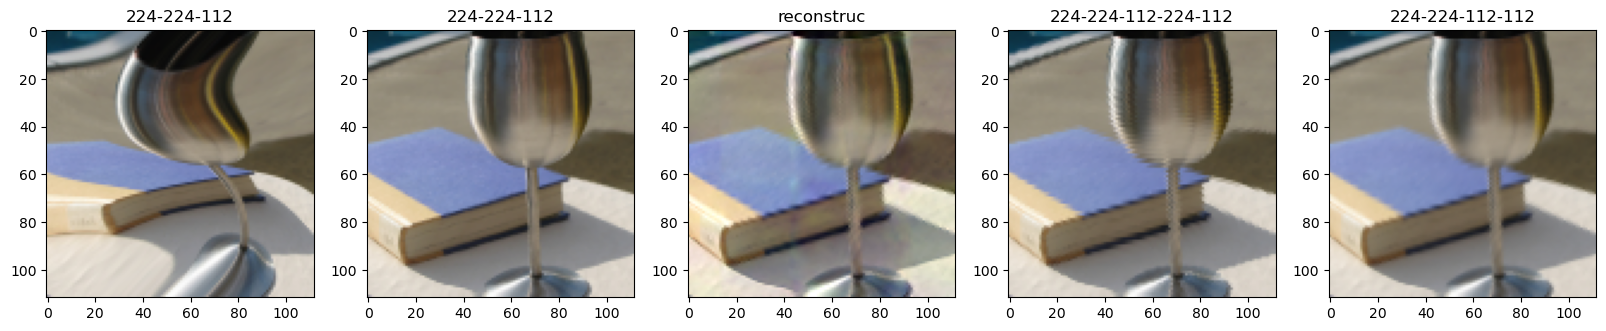

In [48]:
num_of_fig = 5
side_length = 4
fig, axes = plt.subplots(1, num_of_fig, figsize = (num_of_fig * side_length, side_length))
axes[0].imshow(toImage(image_dis_224_224_112.squeeze()))
axes[0].set_title('224-224-112')

axes[1].imshow(toImage(image_inv_224_224_112.squeeze()))
axes[1].set_title('224-224-112')

axes[4].imshow(toImage(image_inv_224_224_112_112.squeeze()))
axes[4].set_title('224-224-112-112')

axes[3].imshow(toImage(image_inv_224_224_112_224_112.squeeze()))
axes[3].set_title('224-224-112-224-112')

axes[2].imshow(toImage(reconstruc.squeeze()))
axes[2].set_title('reconstruc')

In [12]:
reconstruc.shape

torch.Size([1, 3, 112, 112])

In [13]:
reconstruc[0,:, 100:, 40:60]

tensor([[[0.5056, 0.5080, 0.5260, 0.5280, 0.5279, 0.5264, 0.5301, 0.5282,
          0.5246, 0.5349, 0.5365, 0.5303, 0.5300, 0.5298, 0.5333, 0.5419,
          0.5482, 0.5422, 0.5176, 0.4833],
         [0.5155, 0.5197, 0.5314, 0.5410, 0.5381, 0.5400, 0.5446, 0.5445,
          0.5398, 0.5444, 0.5412, 0.5383, 0.5366, 0.5413, 0.5556, 0.5464,
          0.4915, 0.4137, 0.3753, 0.3627],
         [0.5280, 0.5351, 0.5405, 0.5398, 0.5383, 0.5439, 0.5493, 0.5523,
          0.5498, 0.5508, 0.5472, 0.5494, 0.5475, 0.5292, 0.4669, 0.3835,
          0.3415, 0.3352, 0.3307, 0.3287],
         [0.5309, 0.5318, 0.5414, 0.5419, 0.5474, 0.5564, 0.5556, 0.5483,
          0.5435, 0.5480, 0.5510, 0.5468, 0.4936, 0.3926, 0.3359, 0.3278,
          0.3239, 0.3151, 0.3224, 0.3821],
         [0.5316, 0.5301, 0.5339, 0.5356, 0.5537, 0.5627, 0.5637, 0.5592,
          0.5555, 0.5576, 0.5513, 0.4864, 0.3809, 0.3529, 0.3486, 0.3374,
          0.3434, 0.3753, 0.4116, 0.4386],
         [0.5460, 0.5463, 0.5514, 0.5493, 0.5

In [ ]:
U, S_ref, Vh = t.linalg.svd(image_ref_224_112)
U_0, S_0, Vh_0 = t.linalg.svd(image_dis_224_224_112)
U_1, S_1, Vh_1 = t.linalg.svd(image_inv_224_224_112)
U_2, S_2, Vh_2 = t.linalg.svd(image_inv_224_224_112_112)
U_3, S_3, Vh_3 = t.linalg.svd(image_inv_224_224_112_224_112)

(0.0, 112.0)

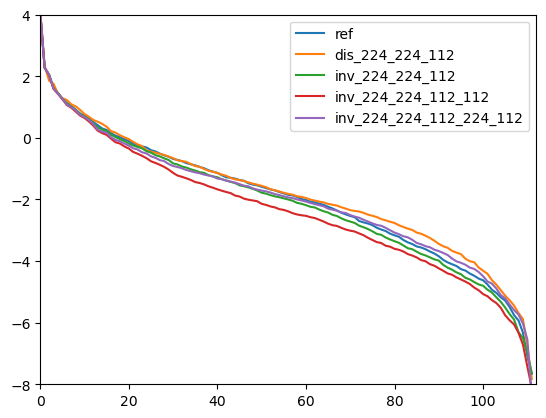

In [11]:
plt.plot(np.log((S_ref.mean(1)).detach().cpu().numpy().T), label = 'ref')

plt.plot(np.log((S_0.mean(1)).detach().cpu().numpy().T), label = 'dis_224_224_112')
plt.plot(np.log((S_1.mean(1)).detach().cpu().numpy().T), label = 'inv_224_224_112')
plt.plot(np.log((S_2.mean(1)).detach().cpu().numpy().T), label = 'inv_224_224_112_112')
plt.plot(np.log((S_3.mean(1)).detach().cpu().numpy().T), label = 'inv_224_224_112_224_112')
plt.legend()

plt.ylim(-8,4)
plt.xlim(0,112)

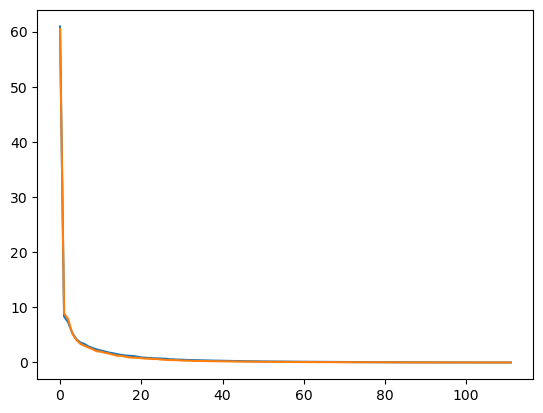

In [15]:
plt.plot(S_0[0,0].cpu())
plt.plot(S_2[0,0].cpu())